### Prematurity classification on the dHCP database.

In [18]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt



In [19]:
region = "STs_right"

labels_path = "/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/participants.csv"
base_path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation"
    

region_path = os.path.join(base_path, region)
    
# Trouver le nom du dossier unique automatiquement
subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
if len(subdirs) != 1:
    raise RuntimeError(f"Il y a {len(subdirs)} sous-dossiers dans {region_path}, impossible de choisir automatiquement car il y a plusieurs modèles enregistrés par région.")
model_folder = subdirs[0]

# Construire les chemins complets
embedding_path = os.path.join(region_path, model_folder, "dHCP_random_embeddings", "full_embeddings.csv")

In [20]:

# Load embeddings and labels
labels_df = pd.read_csv(labels_path)
embeddings = pd.read_csv(embedding_path, index_col=0)
embeddings= embeddings.loc[embeddings.index.isin(labels_df['Subject'])]

# Visu labels
labels=labels_df["birth_age"]

print("Shape embeddings", embeddings.shape)
print("Shape labels", labels.shape)


Shape embeddings (374, 32)
Shape labels (374,)


In [21]:
# Scaling
scaler = StandardScaler().fit(embeddings)
Xs = scaler.transform(embeddings)


# Stratification and brackets
tranches = {
    '<27': {'mask': (labels < 27)},
    '27-32': {'mask': (labels >= 27) & (labels < 32)},
    '32-37': {'mask': (labels >= 32) & (labels < 37)}
}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=8)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

results = {}



# Training loop with strat k-fold and grid search
for name, info in tranches.items():
    # Get the two classes for each classifier
    mask_pre = info['mask']
    mask_term = (labels >= 37)
    mask = mask_pre | mask_term
    X_sub = Xs[mask.values]
    y_sub = np.where(mask_pre[mask], 1, 0)

    # GridSearch with stratified cross-validation
    grid = GridSearchCV(
        SVC(class_weight='balanced', probability=False,kernel='linear'),
        param_grid=param_grid,
        cv=skf,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid.fit(X_sub, y_sub)

    # Cross-validation AUC scores (1 par fold)
    cv_scores = cross_val_score(
        grid.best_estimator_, X_sub, y_sub,
        cv=skf, scoring='roc_auc', n_jobs=-1
    )

    # Mean and std of AUC
    auc_mean = np.mean(cv_scores)
    auc_std = np.std(cv_scores)

    # Permutation test
    n_perm = 200
    auc_null = []
    for _ in range(n_perm):
        y_perm = np.random.permutation(y_sub)
        grid.fit(X_sub, y_perm)
        perm_scores = cross_val_predict(
            grid.best_estimator_, X_sub, y_perm,
            cv=skf, method='decision_function', n_jobs=-1
        )
        auc_null.append(roc_auc_score(y_perm, perm_scores))
    p_value = np.mean(np.array(auc_null) >= auc_mean)
    ci95 = np.percentile(auc_null, 95)

    # Store results
    results[name] = {
        'best_params': grid.best_params_,
        'AUC_mean': auc_mean,
        'AUC_std': auc_std,
        'p_value': p_value,
        'null95': ci95
    }




Résultats par tranche:
Tranche <27: AUC=0.861 ± 0.035, p=0.000, params={'C': 0.001}
Tranche 27-32: AUC=0.804 ± 0.005, p=0.000, params={'C': 0.1}
Tranche 32-37: AUC=0.527 ± 0.068, p=0.530, params={'C': 0.001}


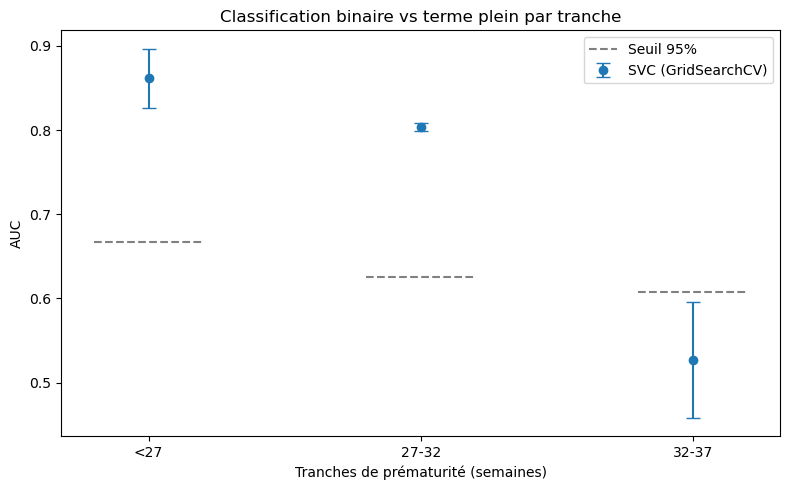

In [22]:
# Plot AUCs
print("Résultats par tranche:")
for name, res in results.items():
    print(f"Tranche {name}: AUC={res['AUC_mean']:.3f} ± {res['AUC_std']:.3f}, p={res['p_value']:.3f}, params={res['best_params']}")


labels_tr = list(results.keys())
aucs = [results[t]['AUC_mean'] for t in labels_tr]
stds = [results[t]['AUC_std'] for t in labels_tr]
ci95s = [results[t]['null95'] for t in labels_tr]

plt.figure(figsize=(8, 5))
plt.errorbar(labels_tr, aucs, yerr=stds, fmt='o', capsize=5, label='SVC (GridSearchCV)')
for i, t in enumerate(labels_tr):
    plt.hlines(ci95s[i], i-0.2, i+0.2, linestyles='dashed', colors='gray', label='Seuil 95%' if i == 0 else None)
    
plt.xlabel('Tranches de prématurité (semaines)')
plt.ylabel('AUC')
plt.title('Classification binaire vs terme plein par tranche')
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
from sklearn.linear_model import LogisticRegression

# Paramètres pour régression logistique
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

results = {}

# Boucle d'entraînement avec LogisticRegression
for name, info in tranches.items():
    mask_pre = info['mask']
    mask_term = (labels >= 37)
    mask = mask_pre | mask_term
    X_sub = Xs[mask.values]
    y_sub = np.where(mask_pre[mask], 1, 0)

    # GridSearch avec régression logistique
    grid = GridSearchCV(
        LogisticRegression(class_weight='balanced', solver='liblinear'),
        param_grid=param_grid,
        cv=skf,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid.fit(X_sub, y_sub)

    # Scores de validation croisée
    cv_scores = cross_val_score(
        grid.best_estimator_, X_sub, y_sub,
        cv=skf, scoring='roc_auc', n_jobs=-1
    )
    auc_mean = np.mean(cv_scores)
    auc_std = np.std(cv_scores)

    # Test par permutation
    n_perm = 200
    auc_null = []
    for _ in range(n_perm):
        y_perm = np.random.permutation(y_sub)
        grid.fit(X_sub, y_perm)
        perm_scores = cross_val_predict(
            grid.best_estimator_, X_sub, y_perm,
            cv=skf, method='decision_function', n_jobs=-1
        )
        auc_null.append(roc_auc_score(y_perm, perm_scores))
    p_value = np.mean(np.array(auc_null) >= auc_mean)
    ci95 = np.percentile(auc_null, 95)

    # Stockage des résultats
    results[name] = {
        'best_params': grid.best_params_,
        'AUC_mean': auc_mean,
        'AUC_std': auc_std,
        'p_value': p_value,
        'null95': ci95
    }


Résultats par tranche:
Tranche <27: AUC=0.869 ± 0.091, p=0.000, params={'C': 0.001}
Tranche 27-32: AUC=0.850 ± 0.010, p=0.000, params={'C': 10}
Tranche 32-37: AUC=0.682 ± 0.025, p=0.000, params={'C': 0.001}


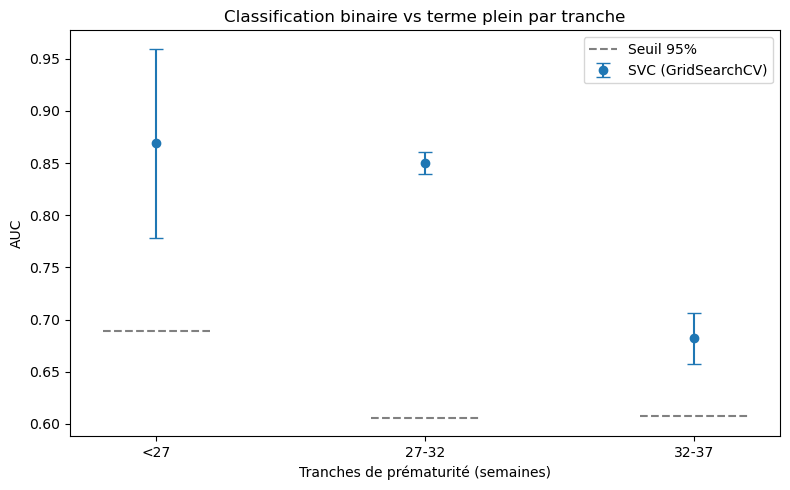

In [20]:
# Plot AUCs
print("Résultats par tranche:")
for name, res in results.items():
    print(f"Tranche {name}: AUC={res['AUC_mean']:.3f} ± {res['AUC_std']:.3f}, p={res['p_value']:.3f}, params={res['best_params']}")


labels_tr = list(results.keys())
aucs = [results[t]['AUC_mean'] for t in labels_tr]
stds = [results[t]['AUC_std'] for t in labels_tr]
ci95s = [results[t]['null95'] for t in labels_tr]

plt.figure(figsize=(8, 5))
plt.errorbar(labels_tr, aucs, yerr=stds, fmt='o', capsize=5, label='SVC (GridSearchCV)')
for i, t in enumerate(labels_tr):
    plt.hlines(ci95s[i], i-0.2, i+0.2, linestyles='dashed', colors='gray', label='Seuil 95%' if i == 0 else None)
    
plt.xlabel('Tranches de prématurité (semaines)')
plt.ylabel('AUC')
plt.title('Classification binaire vs terme plein par tranche')
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
def train_classifier(region, model):
    
    region_path = os.path.join(base_path, region)
    
    # Trouver le nom du dossier unique automatiquement
    subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
    if len(subdirs) != 1:
        raise RuntimeError(f"Il y a {len(subdirs)} sous-dossiers dans {region_path}, impossible de choisir automatiquement car il y a plusieurs modèles enregistrés par région.")
    model_folder = subdirs[0]

    # Construire les chemins complets
    embedding_path = os.path.join(region_path, model_folder, "dHCP_random_embeddings", "full_embeddings.csv")
    embeddings = pd.read_csv(embedding_path, index_col=0)
    embeddings= embeddings.loc[embeddings.index.isin(labels_df['Subject'])]


    # Scaling
    scaler = StandardScaler().fit(embeddings)
    Xs = scaler.transform(embeddings)

    # Stratification and brackets
    tranches = {
        '<27': {'mask': (labels < 27)},
        '27-32': {'mask': (labels >= 27) & (labels < 32)},
        '32-37': {'mask': (labels >= 32) & (labels < 37)}
    }
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=8)
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

    scores = {}

    if model == "SVC":
        classifier = SVC(class_weight='balanced', probability=False,kernel='linear')
    elif model == "LogisticRegression":
        classifier = LogisticRegression(class_weight='balanced', solver='liblinear')



    # Boucle d'entraînement avec LogisticRegression
    for name, info in tranches.items():
        mask_pre = info['mask']
        mask_term = (labels >= 37)
        mask = mask_pre | mask_term
        X_sub = Xs[mask.values]
        y_sub = np.where(mask_pre[mask], 1, 0)

        # GridSearch avec régression logistique
        grid = GridSearchCV(
            classifier,
            param_grid=param_grid,
            cv=skf,
            scoring='roc_auc',
            n_jobs=-1
        )
        grid.fit(X_sub, y_sub)

        # Scores de validation croisée
        cv_scores = cross_val_score(
            grid.best_estimator_, X_sub, y_sub,
            cv=skf, scoring='roc_auc', n_jobs=-1
        )
        auc_mean = np.mean(cv_scores)
        auc_std = np.std(cv_scores)

        # Test par permutation
        n_perm = 200
        auc_null = []
        for _ in range(n_perm):
            y_perm = np.random.permutation(y_sub)
            grid.fit(X_sub, y_perm)
            perm_scores = cross_val_predict(
                grid.best_estimator_, X_sub, y_perm,
                cv=skf, method='decision_function', n_jobs=-1
            )
            auc_null.append(roc_auc_score(y_perm, perm_scores))
        p_value = np.mean(np.array(auc_null) >= auc_mean)
        ci95 = np.percentile(auc_null, 95)

        # Stockage des résultats
        scores[name] = {
            'best_params': grid.best_params_,
            'AUC_mean': auc_mean,
            'AUC_std': auc_std,
            'p_value': p_value,
            'null95': ci95
        }


    return scores 

In [24]:
def get_all_results(regions,model):

    all_results = {}

    for region in regions :
        print(f"Traitement de la région {region}")
        region_scores= train_classifier(region,model)
        all_results[region] = region_scores

    return all_results

In [25]:
def get_region_list(base_path):
    return sorted([
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
           and not d.startswith('all_models')
           and not d.startswith('hcp')
           and not d.startswith('ukb')
           and not d.endswith('.csv')
           and not d.endswith('.sh')
           and not d.endswith('embeddings')
    ])

In [28]:
model="LogisticRegression"

#Construire la liste des régions et calculer les stats
#region_list = ["STs_right"]
region_list = get_region_list(base_path)
stats_all   = get_all_results(region_list,model)

records = []
for region, scores in stats_all.items():
    for tranche, metrics in scores.items():
        records.append({
            "region":       region,
            "tranche":      tranche,
            "best_params":  metrics["best_params"], 
            "AUC_mean":     metrics["AUC_mean"],    
            "AUC_std":      metrics["AUC_std"],
            "p_value":      metrics["p_value"],
            "null95":       metrics["null95"],
        })
df_results = pd.DataFrame(records)

# Export CSV
output_csv = "prematurity_classification_stats_1205.csv"
df_results.to_csv(output_csv, index=False)
print(f"Résultats exportés dans : {output_csv}")



Traitement de la région CINGULATE_left
Traitement de la région CINGULATE_right
Traitement de la région FCLp-subsc-FCLa-INSULA_left
Traitement de la région FCLp-subsc-FCLa-INSULA_right
Traitement de la région FCMpost-SpC_left
Traitement de la région FCMpost-SpC_right
Traitement de la région FColl-SRh_left
Traitement de la région FColl-SRh_right
Traitement de la région FIP_left
Traitement de la région FIP_right
Traitement de la région FPO-SCu-ScCal_left
Traitement de la région FPO-SCu-ScCal_right
Traitement de la région LARGE_CINGULATE_left
Traitement de la région LARGE_CINGULATE_right
Traitement de la région Lobule_parietal_sup_left
Traitement de la région Lobule_parietal_sup_right
Traitement de la région OCCIPITAL_left
Traitement de la région OCCIPITAL_right
Traitement de la région SC-SPeC_left
Traitement de la région SC-SPeC_right
Traitement de la région SC-SPoC_left
Traitement de la région SC-SPoC_right
Traitement de la région SC-sylv_left
Traitement de la région SC-sylv_right
Traite

In [8]:
df = pd.read_csv('/neurospin/dico/rmenasria/Runs/01_essai/Program/2023_jlaval_STSbabies/contrastive/notebooks/racim/prematurity_classification_stats_1205.csv')

# Pivot pour avoir une colonne AUC par tranche
df_pivot = df.pivot(index='region', columns='tranche', values='AUC_mean')

# Renommer les colonnes pour clarifier
df_pivot = df_pivot.rename(columns={
    '<27': 'AUC_27',
    '27-32': 'AUC_27_32',
    '32-37': 'AUC_32_37'
}).reset_index()

# Sauvegarder le nouveau CSV
output_csv = 'prematurity_AUC_by_region_1205.csv'
df_pivot.to_csv(output_csv, index=False)
print(f"Fichier généré : {output_csv}")





Fichier généré : prematurity_AUC_by_region_1205.csv


In [9]:
# Charger le fichier CSV d'origine
df = pd.read_csv('/neurospin/dico/rmenasria/Runs/01_essai/Program/2023_jlaval_STSbabies/contrastive/notebooks/racim/prematurity_classification_stats_1205.csv')

# Remplacer les AUC_mean non significatifs (p_value >= 0.05) par 0
df.loc[df['p_value'] >= 0.1, 'AUC_mean'] = 0.0

# Pivot pour avoir une colonne AUC par tranche
df_pivot = df.pivot(index='region', columns='tranche', values='AUC_mean')

# Renommer les colonnes
df_pivot = df_pivot.rename(columns={
    '<27': 'AUC_27',
    '27-32': 'AUC_27_32',
    '32-37': 'AUC_37'
}).reset_index()

# Exporter le résultat
output_csv = 'prematurity_AUC_by_region_thresholded_1205.csv'
df_pivot.to_csv(output_csv, index=False)
print(f"Fichier généré : {output_csv}")


Fichier généré : prematurity_AUC_by_region_thresholded_1205.csv
